In [ ]:
!pip install keras-visualizer

In [ ]:
!pip install astroNN

     |████████████████████████████████| 9.3 MB 6.3 MB/s 
     |████████████████████████████████| 4.5 MB 3.5 MB/s 
     |████████████████████████████████| 832 kB 40.8 MB/s 
     |████████████████████████████████| 48 kB 4.5 MB/s 
     |████████████████████████████████| 4.0 MB 32.2 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284595 sha256=aeb8e7b4748670e240ea943f6cbb09590d1c787ebc6306a7fa1efecc49bb6a79
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astroNN


In [ ]:
from keras_visualizer import visualizer

In [ ]:
import numpy as np
from tensorflow.keras import utils
from tensorflow.keras import layers
from astroNN.datasets import load_galaxy10
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import numpy as np
from sklearn.model_selection import train_test_split
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
from PIL import Image as im

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [ ]:
#Load Data
dataset = load_galaxy10()

Galaxy10.h5:  99%|█████████▉| 209M/210M [00:03<00:00, 75.2MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:05, 38.6MB/s]                           


In [ ]:
images, labels = dataset

(69, 69, 3)


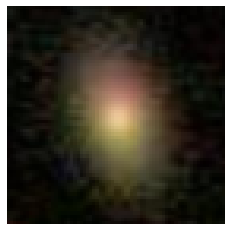

In [ ]:
print(images[0].shape)
first_image = im.fromarray(images[0])
plt.axis("off")
plt.imshow(first_image)

In [ ]:
#Remove low count classes
del_idx = []

for idx, label in enumerate(labels):
  if (label in [3,5,6,8,9]): del_idx.append(idx)

labels = np.delete(labels, del_idx)
images = np.delete(images, del_idx, 0)
labels = np.where(labels == 4, 3, labels)
labels = np.where(labels == 7, 4, labels)

In [ ]:
labels = utils.to_categorical(labels, 5)
labels = labels.astype(np.float32)
images = images.astype(np.float32)

In [ ]:
print(labels.shape)

(19405, 5)


In [ ]:
# Datasets
train_idx, val_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2)
train_ds, train_labels, val_ds, val_labels = images[train_idx], labels[train_idx], images[val_idx], labels[val_idx]
val_img = val_ds
train_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels)).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((val_ds, val_labels)).batch(128)

In [ ]:
# Lookup class labels
class_names = []
for i in [0,1,2,4,7]:
  class_names.append(galaxy10cls_lookup(i))
print(class_names)
num_classes = 5

['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Disk, Edge-on, Rounded Bulge', 'Disk, Face-on, Tight Spiral']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='nearest', interpolation='bilinear', seed=None, fill_value=0.0)
  ]
)

In [ ]:
def create_model():
  model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.Input(shape=(69, 69, 3)),
    layers.Conv2D(32, kernel_size=7, strides=2, padding="same"),
    layers.MaxPool2D(),
    layers.LeakyReLU(alpha=0.4),
    layers.Conv2D(32, kernel_size=7, strides=2, padding="same"),
    layers.MaxPool2D(),
    layers.LeakyReLU(alpha=0.4),
    layers.Conv2D(64, kernel_size=7, strides=2, padding="same"),
    layers.MaxPool2D(),
    layers.LeakyReLU(alpha=0.4),
    layers.Conv2D(128, kernel_size=7, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.4),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(5, activation="sigmoid"),
  ])
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
    
  )
  return model
model = create_model()
#model.summary()

In [ ]:
epochs = 400
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/400
122/122 [==============================] - 17s 38ms/step - loss: 1.4753 - accuracy: 0.3216 - val_loss: 1.3401 - val_accuracy: 0.4058
Epoch 2/400
122/122 [==============================] - 4s 31ms/step - loss: 1.3446 - accuracy: 0.3891 - val_loss: 1.2728 - val_accuracy: 0.4200
Epoch 3/400
122/122 [==============================] - 4s 31ms/step - loss: 1.2781 - accuracy: 0.4125 - val_loss: 1.2016 - val_accuracy: 0.4553
Epoch 4/400
122/122 [==============================] - 4s 31ms/step - loss: 1.2107 - accuracy: 0.4516 - val_loss: 1.1314 - val_accuracy: 0.5024
Epoch 5/400
122/122 [==============================] - 4s 31ms/step - loss: 1.1436 - accuracy: 0.5018 - val_loss: 1.0632 - val_accuracy: 0.5527
Epoch 6/400
122/122 [==============================] - 4s 31ms/step - loss: 1.0805 - accuracy: 0.5413 - val_loss: 0.9969 - val_accuracy: 0.6011
Epoch 7/400
122/122 [==============================] - 4s 30ms/step - loss: 1.0272 - accuracy: 0.5796 - val_loss: 0.9412 - val_accuracy

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']

In [ ]:
print(max(y_vacc))

0.8433393239974976


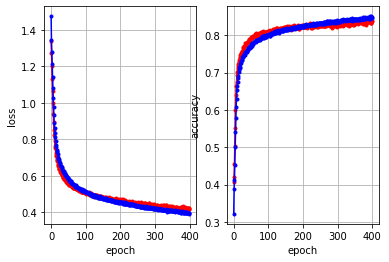

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
ax1.grid()
plt.setp(ax1, xlabel='epoch', ylabel='loss')

ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
ax2.grid()
plt.setp(ax2, xlabel='epoch', ylabel='accuracy')

plt.show()


In [ ]:
preds = model.predict(val_ds)
cs = np.argmax(preds, axis=1)
print(cs.shape)
print(val_img.shape)

(3881,)
(3881, 69, 69, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

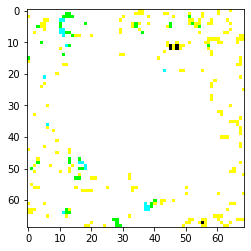

In [ ]:
for idx, i in enumerate(cs):
  if(i!= 4): continue
  img = val_img[idx]
  plt.imshow(img)